In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
data = pd.read_csv("credit_risk_dataset.csv")
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [85]:
data.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [86]:
data.dropna(inplace=True)

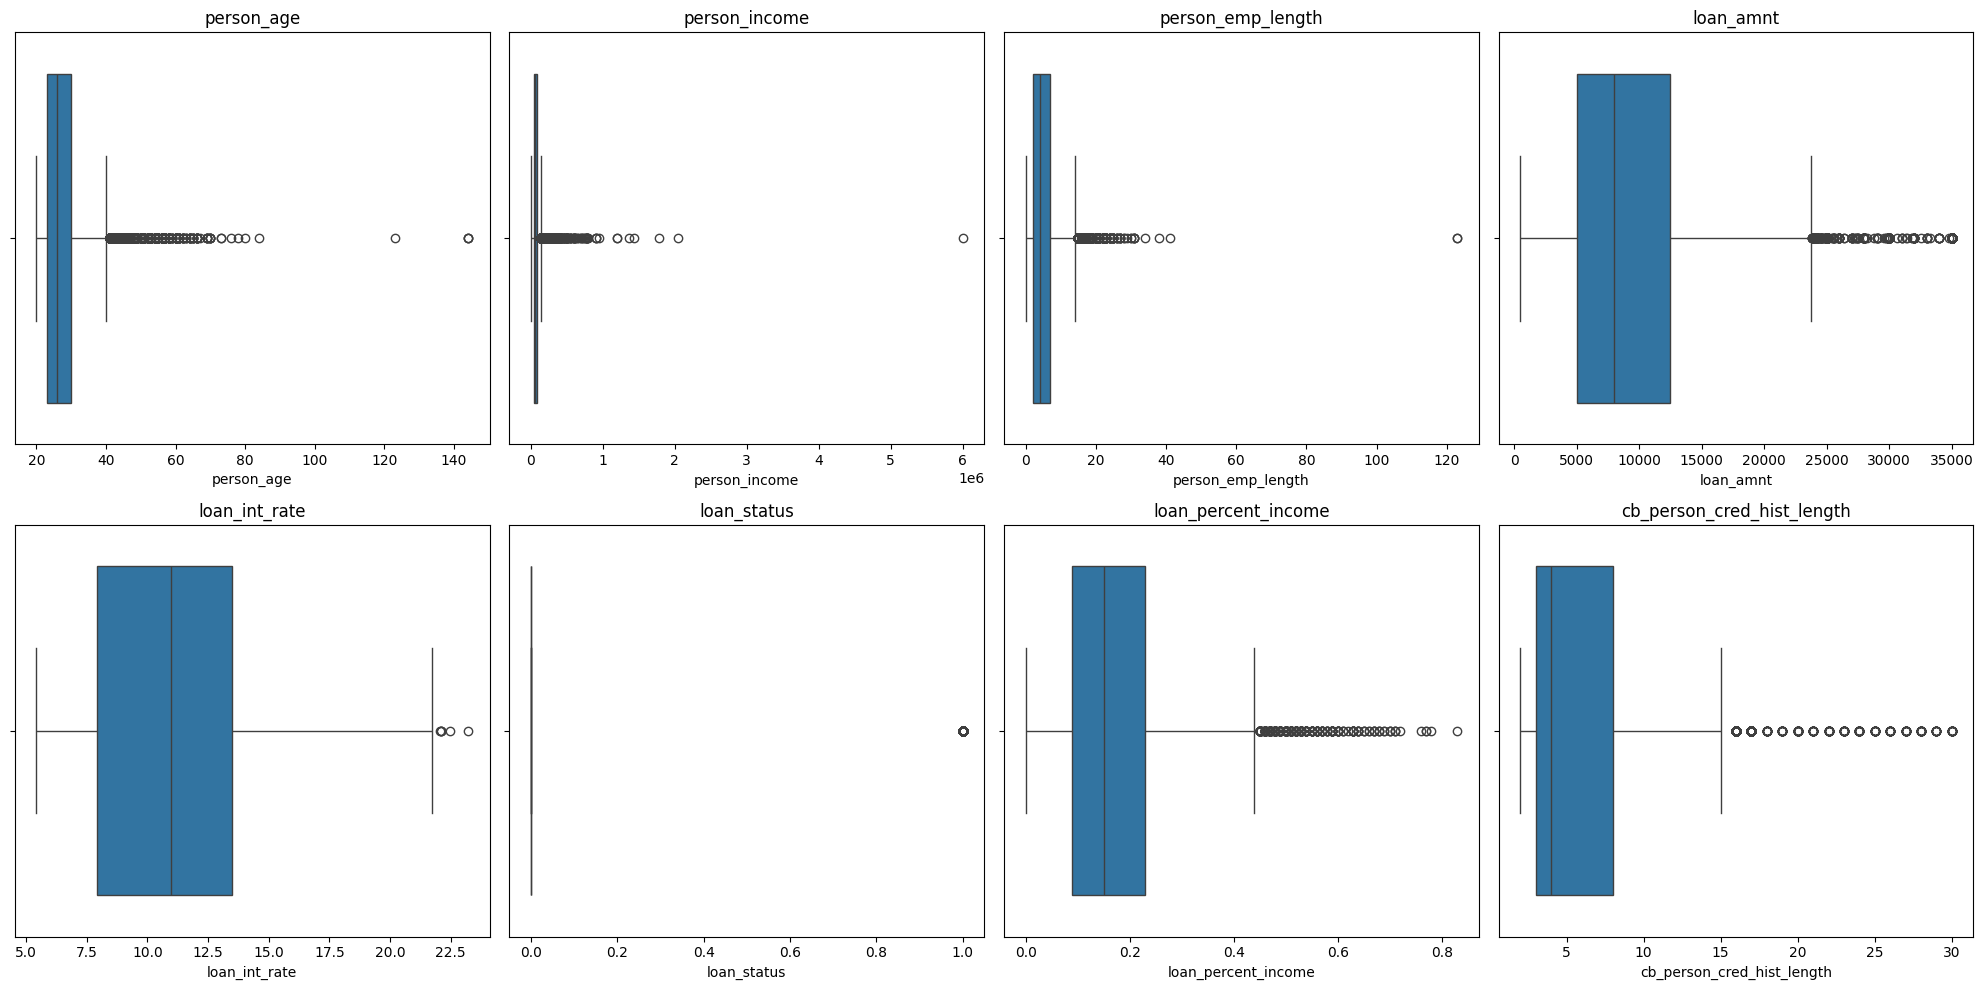

In [87]:
col_numericas = data.select_dtypes(include='number').columns.tolist()

plt.figure(figsize=(20, 10))

for i in range(len(col_numericas)):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x=data[col_numericas[i]])
    plt.title(col_numericas[i])

plt.tight_layout()
plt.show()

In [88]:
#Filter data
def iqr(data, column): #Inter quantile range
    q3 = data[column].quantile(0.75) #3er cuartil
    q1 = data[column].quantile(0.25) #1er cuartil
    superior_limit = q3 + 1.5*(q3 - q1)
    inferior_limit = q1 - 1.5*(q3 - q1)
    return data[(data[column] < superior_limit) & (data[column] > inferior_limit)] #Selects data

In [89]:
for col in ["person_age","person_income","person_emp_length","loan_amnt","loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]:
    data = iqr(data, col) #Uses IQR

data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
9,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3
19,24,10800,MORTGAGE,8.0,EDUCATION,B,1750,10.99,1,0.16,N,2
23,24,10980,OWN,0.0,PERSONAL,A,1500,7.29,0,0.14,N,3
...,...,...,...,...,...,...,...,...,...,...,...,...
32215,39,24000,RENT,1.0,DEBTCONSOLIDATION,A,8500,7.49,1,0.35,N,12
32222,36,136000,MORTGAGE,0.0,EDUCATION,C,4800,14.72,0,0.04,Y,12
32230,37,65000,RENT,7.0,HOMEIMPROVEMENT,C,12000,13.98,0,0.18,N,12
32243,37,68480,RENT,2.0,MEDICAL,C,3600,15.23,0,0.05,Y,11


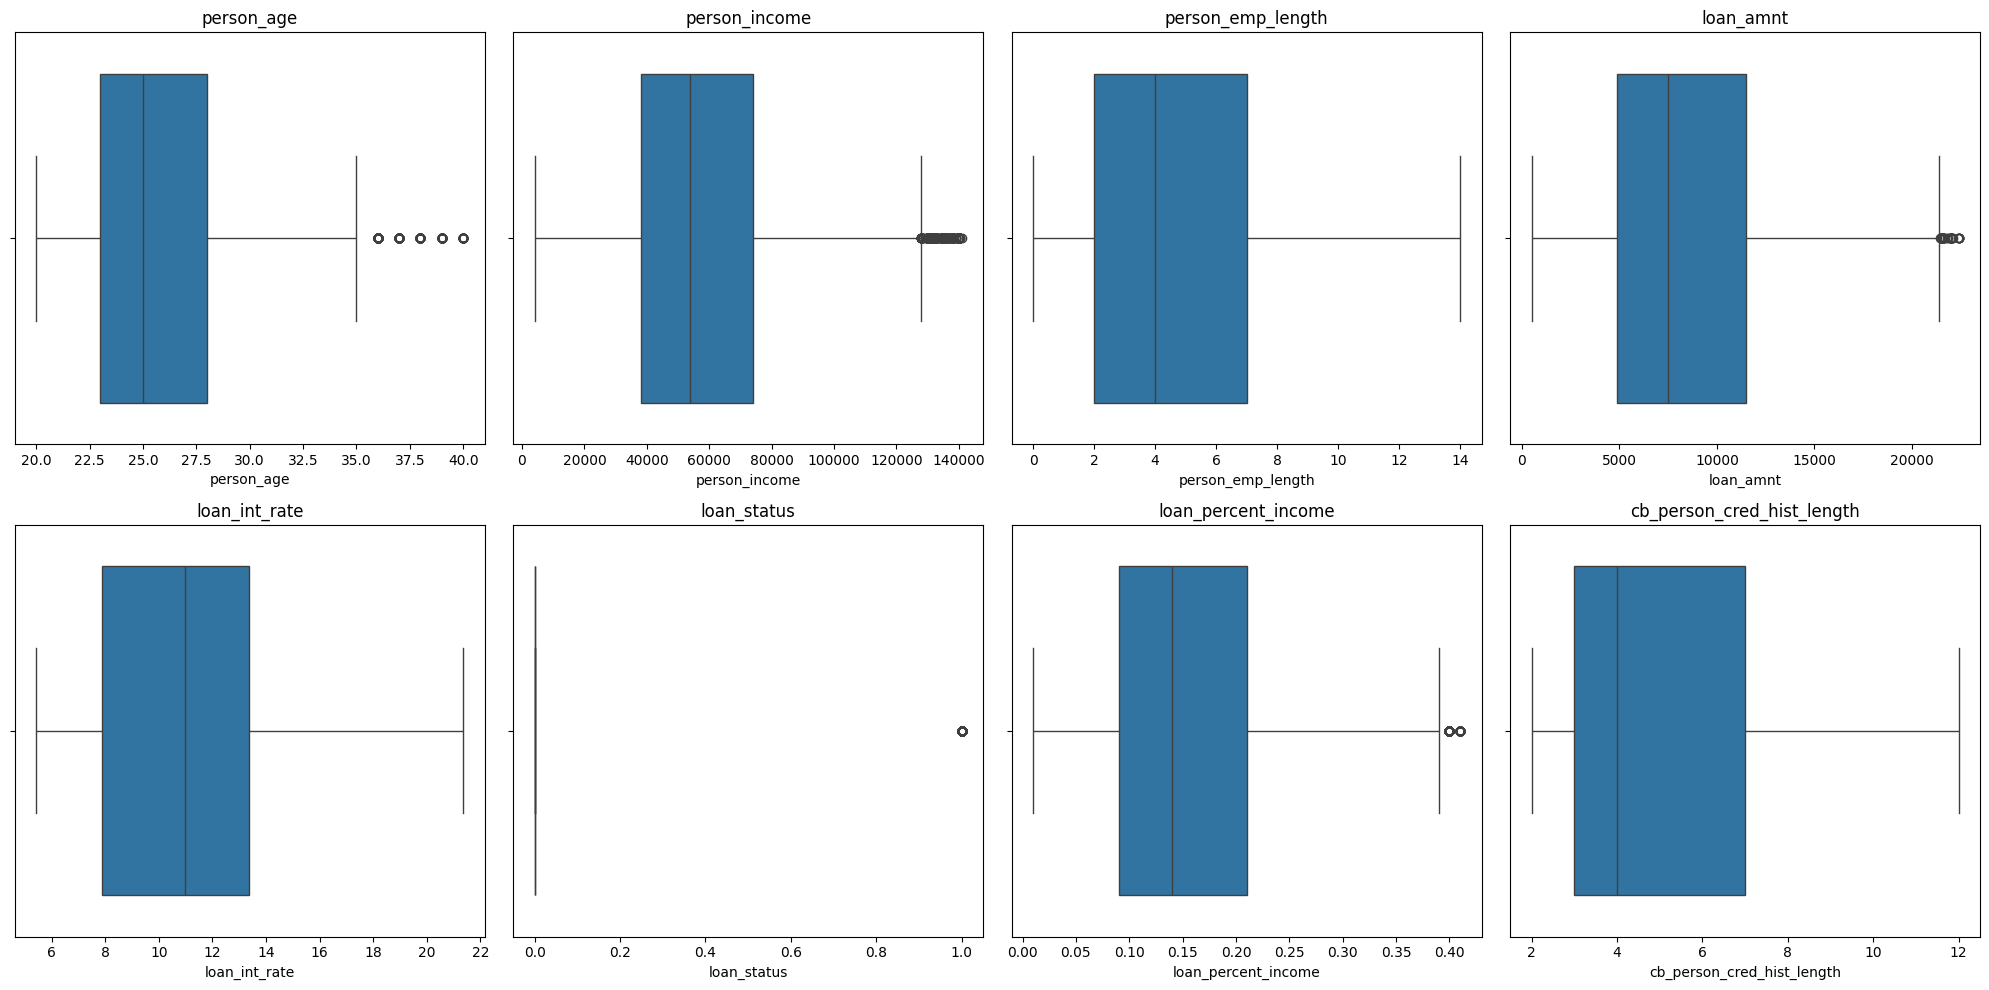

In [90]:
# Seleccionar columnas numéricas
col_numericas = data.select_dtypes(include='number').columns.tolist()

plt.figure(figsize=(20, 10))
for i in range(len(col_numericas)):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x=data[col_numericas[i]])
    plt.title(col_numericas[i])

plt.tight_layout()
plt.show()

In [91]:
from sklearn.preprocessing import LabelEncoder
VC = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]
LE = LabelEncoder()
for i in VC:
    data[i] = LE.fit_transform(data[i])

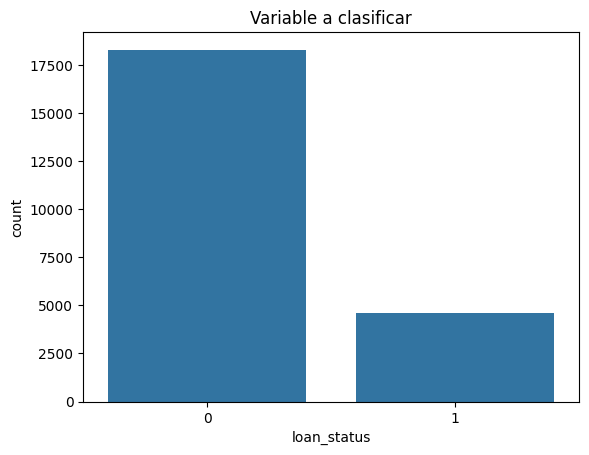

In [92]:
sns.countplot(x = 'loan_status', data = data)
plt.title('Variable a clasificar')
plt.show()
#Hay un desbalance presente indicando que hay mas estados de prestamos pagados que no pagados

Separar variable x e y

In [93]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']

<Axes: >

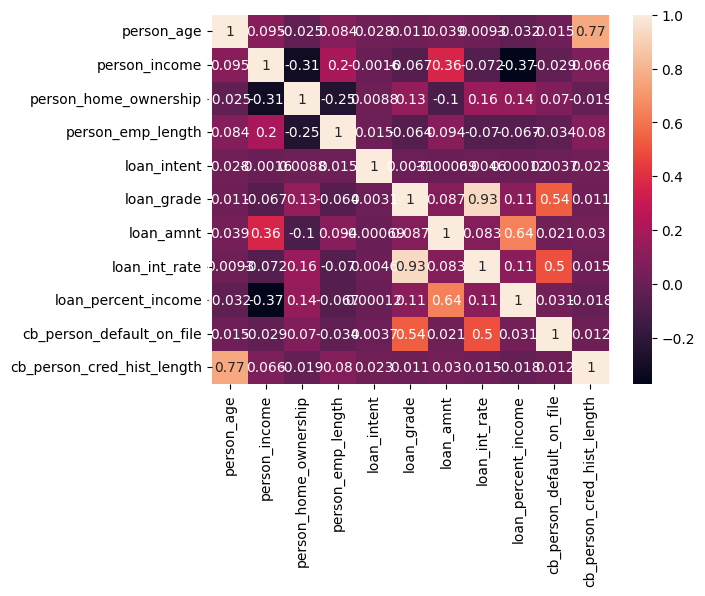

In [94]:
correlation_matrix = X.corr() #Calcula la matriz de correlacion
sns.heatmap(correlation_matrix, annot=True) #Plots heatmap
#Redundancia en las features

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
from sklearn.ensemble import RandomForestClassifier
# Crear modelo Random Forest
modeloRF = RandomForestClassifier(
    n_estimators=300, #300 arboles
    max_depth=50,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

In [111]:
# Entrenar el modelo
modeloRF.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=50, n_estimators=300,
                       random_state=42)

In [112]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
# Predicciones con validación cruzada
y_pred = cross_val_predict(modeloRF, X, y, cv=10)

# Métricas
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     18300
           1       0.92      0.65      0.76      4584

    accuracy                           0.92     22884
   macro avg       0.92      0.82      0.86     22884
weighted avg       0.92      0.92      0.91     22884



In [99]:
X

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,2,5.0,1,1,1000,11.14,0.10,0,2
5,21,9900,2,2.0,5,0,2500,7.14,0.25,0,2
9,21,10000,2,6.0,5,3,1600,14.74,0.16,0,3
19,24,10800,0,8.0,1,1,1750,10.99,0.16,0,2
23,24,10980,2,0.0,4,0,1500,7.29,0.14,0,3
...,...,...,...,...,...,...,...,...,...,...,...
32215,39,24000,3,1.0,0,0,8500,7.49,0.35,0,12
32222,36,136000,0,0.0,1,2,4800,14.72,0.04,1,12
32230,37,65000,3,7.0,2,2,12000,13.98,0.18,0,12
32243,37,68480,3,2.0,3,2,3600,15.23,0.05,1,11


Matriz de Confusión:
 [[18037   263]
 [ 1598  2986]]


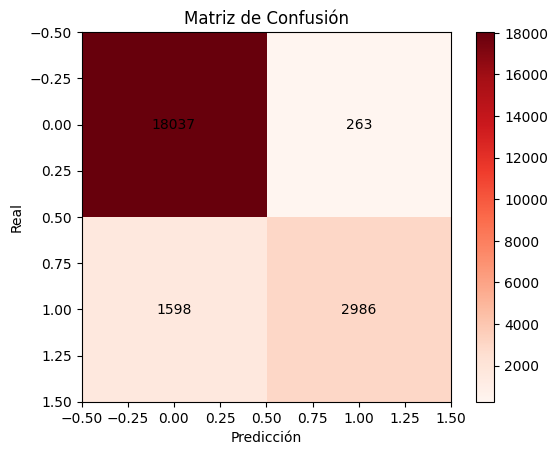

In [100]:
from sklearn.metrics import confusion_matrix

MC = confusion_matrix(y, y_pred)
print("Matriz de Confusión:\n", MC)

plt.imshow(MC, cmap='Reds')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.colorbar()
for i in range(len(MC)):
    for j in range(len(MC)):
        plt.text(j, i, MC[i, j], ha='center', va='center')
plt.show()

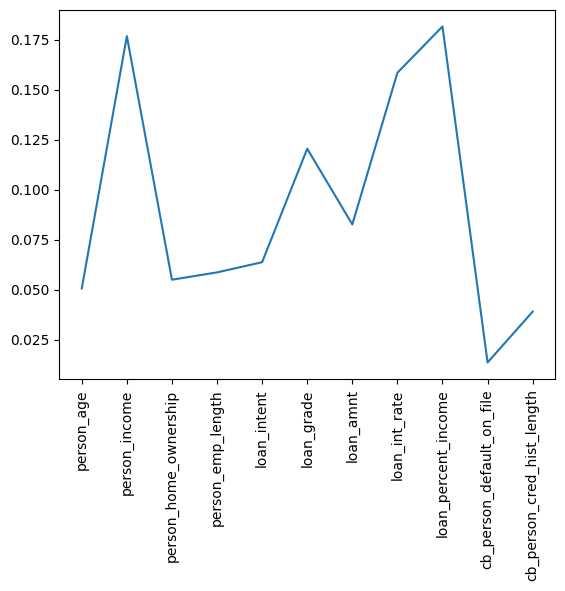

In [101]:
importances = modeloRF.feature_importances_
plt.plot(X_train.columns,importances)
plt.xticks(rotation = 90)
plt.show()

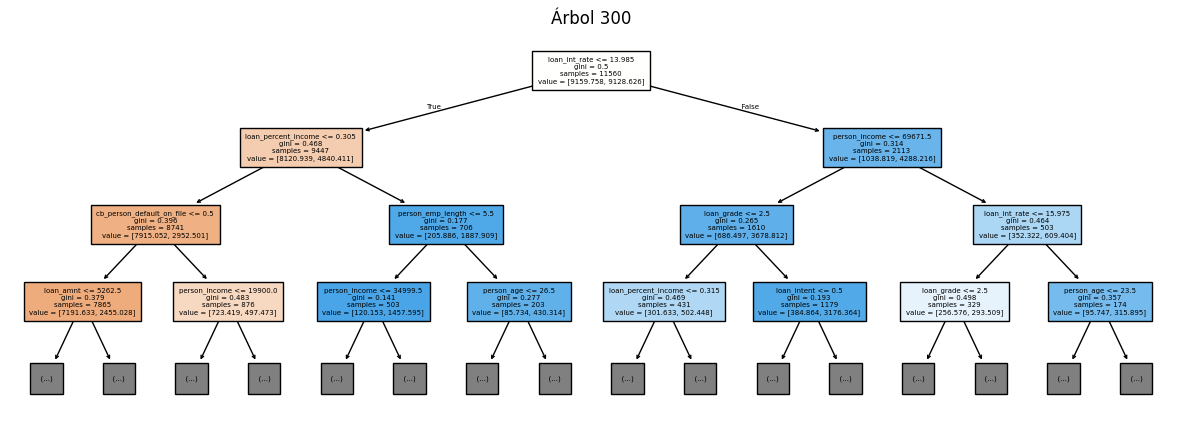

In [ ]:
#Grafico del arbol 300, mostrando solo una profundidad de 3
from sklearn.tree import plot_tree
# Mostrar el árbol 0
plt.figure(figsize=(15, 5))
plot_tree(modeloRF.estimators_[299], feature_names=X.columns, filled=True, max_depth=3, fontsize=5)
plt.title("Árbol 300")
plt.show()